## JWST Pipeline Validation Testing Notebook: NIRISS/SOSS Time Series Observation, pt. 3
**Instruments affected**: NIRISS

### Table of Contents
1. [Imports](#Imports_ID)

2. [Introduction](#intro)

3. [The `outlier_detection` step](#outlier_detection)

### <a id=#Imports_ID>Imports</a>

Here are the lirbaries being imported here and why:

- `numpy` for numerical calculations.
- `matplotlib.pyplot` for plots.
- `astropy.io.fits` for importing fits files.
- `jwst.pipeline.calwebb_tso3` for using the CalWebb TSO3 stage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import medfilt
import os

from astropy.io import fits
from jwst.pipeline import calwebb_tso3
from jwst import datamodels

Version of the pipeline we are testing:

In [2]:
import jwst
print(jwst.__version__)

0.17.1


## <a id='intro'> Introduction </a>

In this notebook we'll be testing that the Stage 3 of the CalWebb TSO pipeline works as intended as a whole. We'll stop after every step to quickly check that the results make sense. The whole set of steps ran by TSOs by this third Stage of the CalWebb Pipeline can be found [<a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html">here</a>]. In what follows, we'll have one section associated to each step, calibrating the data sequentially and exploring the outputs accordingly.

## <a id='outlier_detection'> The `outlier_detection` step </a>

We first test and validate the `outlier_detection` step. This step flags outliers using the time-series of each pixel. It takes the median of each pixel, and then flags pixels which are x-sigma away from this median, using the errors already estimated from previous steps on the flux of each pixel. Let's first make sure our input dataset (the `sourcetypestep`) has all that we need:

In [3]:
hdul = fits.open('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits')

In [4]:
hdul.info()

Filename: output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     179   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (2048, 256, 308)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [50440427B]   


In [5]:
hdul['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2020-12-21T17:41:35.090' / UTC date file created                     
FILENAME= 'data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits' / Name of 
CAL_VER = '0.17.1  '           / Calibration software version number            
CAL_VCS = 'RELEASE '           / Calibration software version control sys number
DATAMODL= 'CubeModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                                                                                
        Observation identifiers                                                 
                            

In [6]:
input_models = datamodels.CubeModel(hdul)

In [7]:
input_models.meta.exposure.type,input_models.meta.exposure.exposure_time

('NIS_SOSS', None)

So we are missing the `exposure_time`. This is needed for the `outlier_detection_step` call, as it is used internally. Let's add it manually, just copying the `DURATION` keyword value to the `EFFEXPTM` which is the one that populates the `exposure_time`. This is not exactly correct, but it will do the trick here:

In [8]:
hdul[0].header.append(('EFFEXPTM', hdul['PRIMARY'].header['DURATION'], '[s] Effective duration of exposure'))

In [9]:
print(hdul['PRIMARY'].header['EFFEXPTM'])

3379.710500000012


All right, now let's save this modified output, and rerun the outlier detection step:

In [10]:
hdul.writeto('output/mod_sourcetypestep.fits')

In [13]:
calwebb_tso3.outlier_detection_step.OutlierDetectionStep.call('output/mod_sourcetypestep.fits', output_dir='output',save_results=True, save_intermediate_results=True)

2020-12-22 01:48:31,657 - stpipe.OutlierDetectionStep - INFO - OutlierDetectionStep instance created.
2020-12-22 01:48:32,066 - stpipe.OutlierDetectionStep - INFO - Step OutlierDetectionStep running with args ('output/mod_sourcetypestep.fits',).
2020-12-22 01:48:32,069 - stpipe.OutlierDetectionStep - INFO - Step OutlierDetectionStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'exptime', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': True, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False}
2020-12-22 01:48:35,178 - stpipe.OutlierDetectionStep - INFO - Performing outlier detection with 3

<CubeModel(308, 256, 2048) from mod_outlierdetectionstep.fits>

In [14]:
hdul_outlier = fits.open('output/mod_outlierdetectionstep.fits')
print(hdul_outlier.info())

Filename: output/mod_outlierdetectionstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     181   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (2048, 256, 308)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [50440466B]   
None


In theory this shouldn't do anything to the data, but it should do something to the `DQ`. Let's substract both:

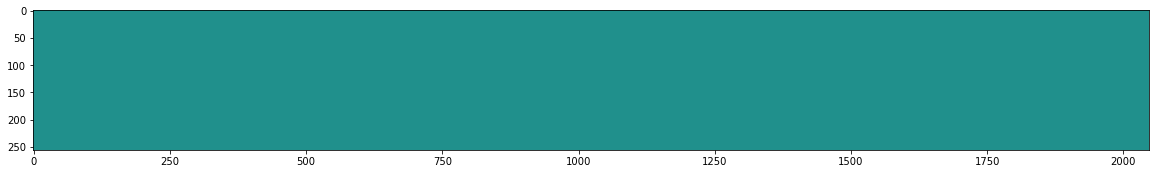

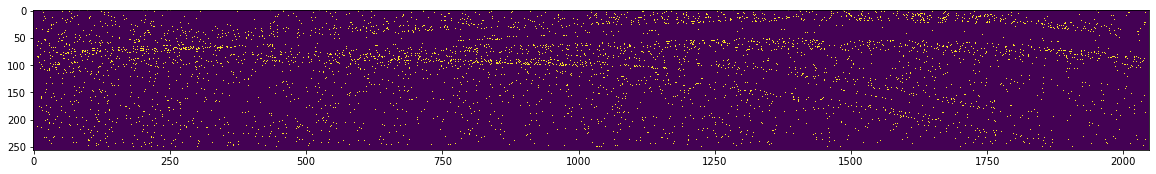

In [15]:
plt.figure(figsize=(20,5))
im = plt.imshow(hdul['SCI'].data[0,:,:] - hdul_outlier['SCI'].data[0,:,:])
im.set_clim(-10,10)
plt.figure(figsize=(20,5))
plt.imshow(hdul['DQ'].data[0,:,:] - hdul_outlier['DQ'].data[0,:,:])
im.set_clim(-10,10)

All right. So some outliers detected, nothing done to the images. Good --- does this apply for all integrations?

In [16]:
data_diff = hdul['SCI'].data - hdul_outlier['SCI'].data
print(np.where(data_diff != 0)[0])

data_diff = hdul['DQ'].data - hdul_outlier['DQ'].data
print(np.where(data_diff != 0)[0])

[]
[  0   0   0 ... 307 307 307]


Yup. For now, outlier detection does not work as planned. But let's continue:

## <a id='extract_1d'> The `extract_1d` step (yes, again) </a>

Let's do our thing:

In [3]:
calwebb_tso3.extract_1d_step.Extract1dStep.call('output/mod_sourcetypestep.fits', output_dir='output',save_results=True)

2020-12-22 01:55:07,720 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2020-12-22 01:55:07,965 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('output/mod_sourcetypestep.fits',).
2020-12-22 01:55:07,967 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}
2020-12-22 01:55:10,778 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_niriss_extract1d_0003.json
2020-12-22 01:55:10,781 - stpipe.Extract1dStep - INFO - APCORR reference file name is "N/A"
2020-12-22 01:55:10,782 - stpipe.Extract1dStep - IN

2020-12-22 01:55:36,716 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:37,202 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:37,685 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:38,134 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:38,576 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:38,996 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:39,466 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:55:39,895 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:56:07,399 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:07,848 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:08,282 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:08,755 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:09,216 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:09,678 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:10,155 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:10,586 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:56:36,508 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:36,995 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:37,462 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:37,897 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:38,333 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:38,792 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:39,256 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:56:39,750 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:57:05,587 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:06,022 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:06,418 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:06,852 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:07,319 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:07,739 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:08,149 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:08,587 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:57:32,034 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:32,484 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:32,937 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:33,356 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:33,763 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:34,213 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:34,641 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:57:35,069 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:58:00,138 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:00,617 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:01,067 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:01,525 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:01,996 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:02,463 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:02,949 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:03,370 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:58:29,872 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:30,308 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:30,734 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:31,164 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:31,602 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:32,028 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:32,443 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:32,862 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:58:57,142 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:57,550 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:57,926 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:58,313 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:58,736 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:59,135 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:59,520 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:58:59,919 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:59:23,463 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:23,861 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:24,253 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:24,646 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:25,056 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:25,432 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:25,826 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:26,226 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 01:59:48,678 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:49,088 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:49,468 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:49,881 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:50,328 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:50,755 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:51,161 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 01:59:51,553 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 02:00:16,241 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:16,643 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:17,042 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:17,443 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:17,832 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:18,266 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:18,688 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:19,084 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 02:00:42,822 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:43,205 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:43,635 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:44,016 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:44,408 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:44,810 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:45,278 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:00:45,659 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 02:01:10,559 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:10,949 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:11,367 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:11,780 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:12,206 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:12,601 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:12,998 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:13,379 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

2020-12-22 02:01:38,472 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:38,904 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:39,355 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:39,819 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:40,272 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:40,719 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:41,183 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-22 02:01:41,619 - stpipe.Extract1dStep - INFO - Using extraction limits: xstart=4, xstop=2044, ystart=20, ystop=220
2020-12-

<MultiSpecModel from mod_extract1dstep.fits>

Let's plot the lightcurve on our own:

In [5]:
hdul_e1d = fits.open('output/mod_extract1dstep.fits')
print(hdul_e1d.info())

Filename: output/mod_extract1dstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     185   ()      
  1  EXTRACT1D     1 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  2  EXTRACT1D     2 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  3  EXTRACT1D     3 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  4  EXTRACT1D     4 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  5  EXTRACT1D     5 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  6  EXTRACT1D     6 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  7  EXTRACT1D     7 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  8  EXTRACT1D     8 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  9  EXTRACT1D     9 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
 10  EXTRACT1D    10 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J,

925  ASDF          1 BinTableHDU     11   1R x 1C   [30242559B]   
None


In [6]:
spec = datamodels.MultiSpecModel(hdul_e1d)

Text(0, 0.5, 'Relative flux')

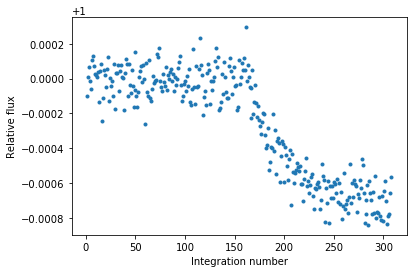

In [8]:
integrations = np.array([])
fluxes = np.array([])
for i in range(308):
    integrations = np.append(integrations, i+1)
    idx = np.where(~np.isnan(spec.spec[i].spec_table['FLUX']))
    fluxes = np.append(fluxes, np.sum(spec.spec[i].spec_table['FLUX'][idx]))
idx = np.where(~np.isnan(fluxes))
plt.plot(integrations, fluxes/np.median(fluxes[idx][0:100]), '.')
plt.xlabel('Integration number')
plt.ylabel('Relative flux')

OK. Good enough. Let's now jump to the white-light step:

## <a id='white-light'> The `white-light` step </a>

In [9]:
calwebb_tso3.white_light_step.WhiteLightStep.call('output/mod_extract1dstep.fits', output_dir='output',save_results=True)

2020-12-22 08:34:25,991 - stpipe.WhiteLightStep - INFO - WhiteLightStep instance created.
2020-12-22 08:34:26,673 - stpipe.WhiteLightStep - INFO - Step WhiteLightStep running with args ('output/mod_extract1dstep.fits',).
2020-12-22 08:34:26,676 - stpipe.WhiteLightStep - INFO - Step WhiteLightStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.ecsv', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'whtlt', 'search_output_file': True, 'input_dir': ''}
2020-12-22 08:35:02,689 - stpipe.WhiteLightStep - WARNING - There is no INT_TIMES table in the input file.


ValueError: Input values did not match the format class mjd:
TypeError: for mjd class, input should be doubles, string, or Decimal, and second values are only allowed for doubles.

We got a `There is no INT_TIMES table in the input file.`. Pretty sure this is an `awesimsoss` issue and not a pipeline one.